<a href="https://colab.research.google.com/github/LiangHao09/Detecctor-de-amarillismo/blob/main/Detecctor_de_amarillismo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Descripción del proyecto**

La desinformación y el sesgo mediático representan uno de los mayores desafíos para las democracias modernas. Con las **elecciones presidenciales de Costa Rica en febrero de 2026** acercándose, este proyecto busca aplicar técnicas de **ciencia de datos** y **procesamiento de lenguaje natural (NLP)** para:

- Recolectar y analizar artículos de prensa costarricenses e internacionales.
- Evaluar automáticamente el **tono emocional** y posibles **sesgos lexicales** según la tendencia ideológica aproximada de cada medio.
- Realizar un **fact-checking automatizado básico**.
- Ofrecer un análisis especial sobre la cobertura de los principales precandidatos y temas de campaña en Costa Rica.

In [1]:
# Instalación de todas las librerías necesarias (solo la primera vez o al reiniciar el entorno)
!pip install -q pandas numpy matplotlib seaborn plotly wordcloud
!pip install -q requests beautifulsoup4 newspaper3k lxml-html-clean
!pip install -q nltk spacy vaderSentiment textblob
!pip install -q scikit-learn feedparser

# Modelo de spaCy en español
!python -m spacy download es_core_news_md -q

print("¡Todas las librerías instaladas correctamente!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 24.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
¡Todas las librerías instaladas correctamente!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import requests
from bs4 import BeautifulSoup
from newspaper import Article
import feedparser
import time
import re
from datetime import datetime, timedelta

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

import spacy
nlp = spacy.load("es_core_news_md")

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

# Semilla para reproducibilidad
np.random.seed(42)

print("Librerías importadas correctamente")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Librerías importadas correctamente


## 1. Definición de fuentes de noticias

Lista amplia y equilibrada de medios costarricenses e internacionales.  
A cada medio se le asigna una **tendencia ideológica aproximada** basada en estudios reconocidos (AllSides, Ad Fontes Media, Media Bias/Fact Check y referencias académicas locales).

**Nota:** Estas etiquetas son aproximaciones y pueden variar según el tema o período.

In [3]:
fuentes = [
    # Costa Rica
    {"nombre": "La Nación", "url": "https://www.nacion.com/", "rss": "https://www.nacion.com/rss/", "tendencia": "centro-derecha", "pais": "CR"},
    {"nombre": "CRHoy", "url": "https://www.crhoy.com/", "rss": "https://www.crhoy.com/feed/", "tendencia": "centro-derecha", "pais": "CR"},
    {"nombre": "Teletica", "url": "https://www.teletica.com/", "rss": "https://www.teletica.com/feed", "tendencia": "centro", "pais": "CR"},
    {"nombre": "La República", "url": "https://www.larepublica.net/", "rss": "https://www.larepublica.net/rss", "tendencia": "centro-derecha", "pais": "CR"},
    {"nombre": "Semanario Universidad", "url": "https://semanariouniversidad.com/", "rss": "https://semanariouniversidad.com/feed/", "tendencia": "centro-izquierda", "pais": "CR"},
    {"nombre": "Delfino.cr", "url": "https://delfino.cr/", "rss": "https://delfino.cr/feed", "tendencia": "centro-izquierda", "pais": "CR"},
    {"nombre": "El Observador", "url": "https://observador.cr/", "rss": None, "tendencia": "derecha", "pais": "CR"},

    # Internacionales (referencia)
    {"nombre": "BBC Mundo", "url": "https://www.bbc.com/mundo", "rss": "https://feeds.bbci.co.uk/mundo/rss.xml", "tendencia": "centro", "pais": "Internacional"},
    {"nombre": "Reuters", "url": "https://www.reuters.com/", "rss": "https://www.reuters.com/rss", "tendencia": "centro", "pais": "Internacional"},
    {"nombre": "The Guardian", "url": "https://www.theguardian.com/international", "rss": "https://www.theguardian.com/world/rss", "tendencia": "centro-izquierda", "pais": "Internacional"},
    {"nombre": "El País", "url": "https://elpais.com/", "rss": "https://feeds.elpais.com/mrss-s/pages/ep/site/elpais.com/section/internacional", "tendencia": "centro-izquierda", "pais": "Internacional"},
]

fuentes_df = pd.DataFrame(fuentes)
fuentes_df[["nombre", "tendencia", "pais"]]

,nombre,tendencia,pais
0,La Nación,centro-derecha,CR
1,CRHoy,centro-derecha,CR
2,Teletica,centro,CR
3,La República,centro-derecha,CR
4,Semanario Universidad,centro-izquierda,CR
5,Delfino.cr,centro-izquierda,CR
6,El Observador,derecha,CR
7,BBC Mundo,centro,Internacional
8,Reuters,centro,Internacional
9,The Guardian,centro-izquierda,Internacional


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('tendencia').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('pais').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['pais'].value_counts()
    for x_label, grp in _df_2.groupby('tendencia')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('tendencia')
_ = plt.ylabel('pais')

## 2. Web scraping y recolección de artículos

Función robusta que usa RSS cuando está disponible y newspaper3k como fallback.  
Se limita a artículos de los últimos 6 meses y se respeta una pausa entre peticiones.

In [4]:
def extraer_articulos_fuente(row, dias=180):
    articulos = []
    fecha_limite = datetime.now() - timedelta(days=dias)

    try:
        if row["rss"]:
            feed = feedparser.parse(row["rss"])
            for entry in feed.entries[:30]:
                if hasattr(entry, "published_parsed") and entry.published_parsed:
                    fecha_pub = datetime(*entry.published_parsed[:6])
                    if fecha_pub < fecha_limite:
                        continue

                articulos.append({
                    "titulo": entry.title,
                    "url": entry.link,
                    "fecha": datetime(*entry.published_parsed[:6]) if hasattr(entry, "published_parsed") and entry.published_parsed else datetime.now(),
                    "medio": row["nombre"],
                    "tendencia": row["tendencia"],
                    "pais": row["pais"],
                    "texto": entry.summary if "summary" in entry else ""
                })
        else:
            # Fallback con newspaper3k
            article =spacy.Article(row["url"])
            article.download()
            if article.is_downloaded:
                article.parse()
                articulos.append({
                    "titulo": article.title or "Sin título",
                    "url": row["url"],
                    "fecha": article.publish_date or datetime.now(),
                    "medio": row["nombre"],
                    "tendencia": row["tendencia"],
                    "pais": row["pais"],
                    "texto": article.text
                })
    except Exception as e:
        print(f"Error con {row['nombre']}: {e}")

    time.sleep(1)
    return articulos

# Recolección (puede tardar varios minutos)
todos_articulos = []
for _, row in fuentes_df.iterrows():
    print(f"Extrayendo de {row['nombre']}...")
    arts = extraer_articulos_fuente(row)
    todos_articulos.extend(arts)

df = pd.DataFrame(todos_articulos)
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
print(f"\nSe recolectaron {len(df)} artículos.")
df.head()

Extrayendo de La Nación...
Extrayendo de CRHoy...
Extrayendo de Teletica...
Extrayendo de La República...
Extrayendo de Semanario Universidad...
Extrayendo de Delfino.cr...
Extrayendo de El Observador...
Error con El Observador: module 'spacy' has no attribute 'Article'
Extrayendo de BBC Mundo...
Extrayendo de Reuters...
Extrayendo de The Guardian...
Extrayendo de El País...

Se recolectaron 121 artículos.


,titulo,url,fecha,medio,tendencia,pais,texto
0,"Alajuela tendrá cierres viales, viernes y sába...",https://www.nacion.com/viva/alajuela-tendra-ci...,2025-12-05 03:21:06,La Nación,centro-derecha,CR,La Municipalidad de Alajuela aplicará cierre v...
1,Gordo Navideño 2025: los números bajos empieza...,https://www.nacion.com/el-pais/gordo-navideno-...,2025-12-05 03:15:35,La Nación,centro-derecha,CR,Los números bajos para el sorteo de la lotería...
2,SOA: el seguro que acompaña su marchamo y resg...,https://www.nacion.com/brandvoice/soa-el-segur...,2025-12-05 02:47:22,La Nación,centro-derecha,CR,Este boletín profundiza en el SOA y en las cob...
3,Exdirector de campaña de Trump asesoró al equi...,https://www.nacion.com/el-mundo/exdirector-de-...,2025-12-05 02:27:43,La Nación,centro-derecha,CR,El medio estadounidense 'The New York Times' r...
4,Sorteo del Mundial 2026: Hora y canales para v...,https://www.nacion.com/puro-deporte/sorteo-del...,2025-12-05 02:09:31,La Nación,centro-derecha,CR,El sorteo del Mundial 2026 acapara la atención...


## 3. Limpieza y preprocesamiento de texto

Pasos clásicos en español:
- Minúsculas
- Eliminación de puntuación y números
- Tokenización
- Eliminación de stopwords
- Lematización con spaCy

In [5]:
stop_words = set(stopwords.words('spanish'))
stop_words.update(['señor', 'señora', 'dijo', 'según', 'además', 'también', 'así', 'ser', 'hacer', 'poder'])

def limpiar_texto(texto):
    if not isinstance(texto, str) or texto == "":
        return ""
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñü\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

def lematizar(texto):
    if texto == "":
        return ""
    doc = nlp(texto)
    return " ".join([token.lemma_ for token in doc if token.text not in stop_words and len(token.text) > 2])

# Aplicamos
df["texto_limpio"] = df["texto"].apply(limpiar_texto)
print("Lematizando (puede tardar unos minutos)...")
df["texto_lem"] = df["texto_limpio"].apply(lematizar)

df[["titulo", "texto_lem"]].head()

Lematizando (puede tardar unos minutos)...


,titulo,texto_lem
0,"Alajuela tendrá cierres viales, viernes y sába...",municipalidad alajuelo aplicar cierre vial var...
1,Gordo Navideño 2025: los números bajos empieza...,número bajo sorteo lotería gordo empezar escas...
2,SOA: el seguro que acompaña su marchamo y resg...,boletín profundizar soa cobertura adicional po...
3,Exdirector de campaña de Trump asesoró al equi...,medio estadounidense the new york times revela...
4,Sorteo del Mundial 2026: Hora y canales para v...,sorteo mundial acaparar atención planeta viern...


## 4. Análisis de sentimiento y emocionalidad

Usamos VADER (funciona razonablemente en español) para obtener un puntaje compuesto de sentimiento (-1 negativo, +1 positivo).

In [6]:
analyzer = SentimentIntensityAnalyzer()

def sentimiento_vader(texto):
    scores = analyzer.polarity_scores(texto)
    return scores['compound']

df["sentimiento"] = df["texto_limpio"].apply(sentimiento_vader)

sent_por_tendencia = df.groupby("tendencia")["sentimiento"].mean().sort_values(ascending=False)
sent_por_tendencia

,sentimiento
tendencia,
centro,0.012397
centro-derecha,-0.082677
centro-izquierda,-0.186387


## 5. Detección de posibles sesgos lexicales

- Nubes de palabras por tendencia  
- Términos más característicos mediante TF-IDF

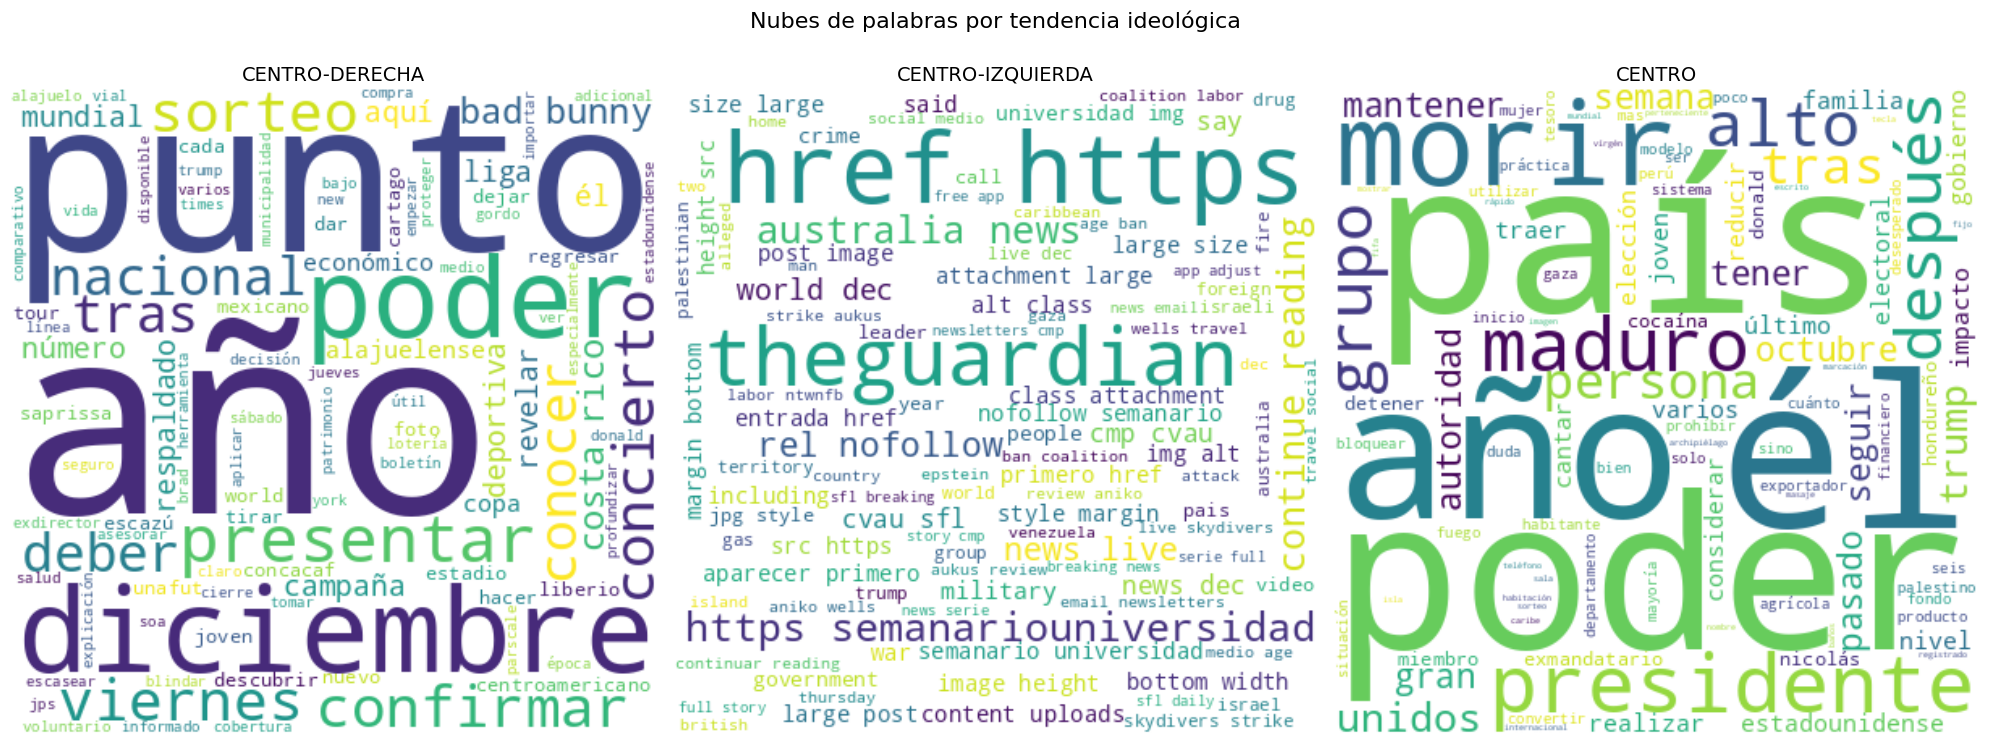


--- CENTRO-DERECHA ---
['año', 'punto', 'conocer', 'tras', 'sorteo', 'confirmar', 'diciembre', 'centroamericano', 'poder', 'económico', 'presentar', 'nacional', 'viernes', 'dar', 'joven']

--- CENTRO-IZQUIERDA ---
['the', 'https', 'com', 'and', 'href', 'www', 'theguardian', 'semanariouniversidad', 'news', 'dec', 'rel', 'large', 'nofollow', 'for', 'australia']

--- CENTRO ---
['poder', 'maduro', 'país', 'él', 'morir', 'presidente', 'alto', 'año', 'persona', 'impacto', 'grupo', 'unidos', 'trump', 'tras', 'gobierno']


In [7]:
# Nubes de palabras
tendencias = df["tendencia"].unique()
fig, axes = plt.subplots(1, len(tendencias), figsize=(20, 8))

for ax, tend in zip(axes, tendencias):
    textos = " ".join(df[df["tendencia"] == tend]["texto_lem"].tolist())
    if textos.strip():
        wc = WordCloud(width=400, height=400, background_color="white", max_words=100).generate(textos)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(tend.upper(), fontsize=14)
        ax.axis("off")

plt.suptitle("Nubes de palabras por tendencia ideológica", fontsize=16)
plt.tight_layout()
plt.show()

# TF-IDF por tendencia
vectorizer = TfidfVectorizer(max_features=5000, min_df=3)
tfidf_matrix = vectorizer.fit_transform(df["texto_lem"])
features = vectorizer.get_feature_names_out()

for tend in tendencias:
    idx = df[df["tendencia"] == tend].index
    tfidf_tend = tfidf_matrix[idx].mean(axis=0).A1
    top_indices = tfidf_tend.argsort()[-20:][::-1]
    print(f"\n--- {tend.upper()} ---")
    print([features[i] for i in top_indices[:15]])

# 6. Análisis exclusivo de Costa Rica (Elecciones 2026) 🔥🇨🇷

Sección especial sobre la cobertura de las elecciones presidenciales de 2026.

In [18]:
candidatos = ["Rodrigo Chaves", "Laura Fernández", "Lineth Saborío", "Welmer Ramos",
              "Pilar Cisneros", "Eli Feinzaig", "Rolando Araya", "Natalia Díaz"]

terminos_eleccion = candidatos + ["elecciones 2026", "primarias", "PLN", "PPSO", "PUSC", "PLN"]

patron = "|".join([re.escape(term.lower()) for term in terminos_eleccion])

df_cr = df[df["texto_limpio"].str.contains(patron, case=False, na=False) |
           df["titulo"].str.contains(patron, case=False, na=False)]

print(f"Artículos relacionados con elecciones 2026 encontrados: {len(df_cr)}")

Artículos relacionados con elecciones 2026 encontrados: 1


In [17]:
# Menciones por candidato
menciones = {}
for cand in candidatos:
    count = df_cr["texto_limpio"].str.contains(cand.lower(), na=False).sum()
    menciones[cand] = count

menciones_df = pd.DataFrame.from_dict(menciones, orient="index", columns=["menciones"]).sort_values("menciones", ascending=False)

# Sentimiento promedio por candidato
sent_cand = {}
for cand in candidatos:
    mask = df_cr["texto_limpio"].str.contains(cand.lower(), na=False)
    if mask.sum() > 0:
        sent_cand[cand] = df_cr[mask]["sentimiento"].mean()

sent_df = pd.DataFrame.from_dict(sent_cand, orient="index", columns=["sentimiento_promedio"])

# Gráficos
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Menciones por candidato", "Sentimiento promedio por candidato"),
                    specs=[[{"type": "bar"}, {"type": "bar"}]])

fig.add_trace(go.Bar(x=menciones_df.index, y=menciones_df["menciones"], name="Menciones"), row=1, col=1)
fig.add_trace(go.Bar(x=sent_df.index, y=sent_df["sentimiento_promedio"], marker_color="orange", name="Sentimiento"), row=1, col=2)

fig.update_layout(height=600, title_text="Cobertura electoral Costa Rica 2026")
fig.show()

## 7. Visualizaciones atractivas

In [19]:
# Boxplot de sentimiento por tendencia
fig = px.box(df, x="tendencia", y="sentimiento", color="tendencia",
             title="Distribución del sentimiento por tendencia ideológica")
fig.show()

# Evolución temporal (solo CR)
if len(df_cr) > 0:
    df_cr["mes"] = df_cr["fecha"].dt.to_period("M").astype(str)
    tono_temporal = df_cr.groupby("mes")["sentimiento"].mean().reset_index()

    fig = px.line(tono_temporal, x="mes", y="sentimiento", markers=True,
                  title="Evolución del tono emocional en cobertura electoral CR")
    fig.add_hline(y=0, line_dash="dash", line_color="gray")
    fig.show()

## 8. Conclusiones y limitaciones

### Hallazgos principales
(Completa según los resultados que obtengas al ejecutar el notebook)

### Limitaciones
- El análisis de sentimiento automatizado tiene precisión limitada en español político.
- Las etiquetas de tendencia son aproximaciones.
- La recolección vía RSS/newspaper3k puede ser incompleta.
- No sustituye el fact-checking humano.

### Mejoras futuras
- Fine-tuning de modelos BERT en español (BETO, RoBERTa-es).
- Dashboard interactivo con Streamlit o Voila.
- Integración de más APIs de fact-checking.

## 9. Referencias y fuentes

- AllSides Media Bias Chart
- Ad Fontes Media
- Media Bias/Fact Check
- Google Fact Check Tools API
- VADER Sentiment (Hutto & Gilbert, 2014)
- spaCy español: es_core_news_md

¡Gracias por explorar este proyecto! Si te interesa colaborar o tienes sugerencias, déjame un comentario. 🇨🇷📊